# Modelos basados en conjuntos 

### Curso Intermedio de Aprendizaje Automático 2021

**Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'  
plt.rcParams["figure.figsize"] = [6,6]

#1. Introducción a los conjuntos

El objetivo de los conjuntos es combinar un conjunto de aprendices (clasificadores/regresores base) para construir un modelo con prestaciones superiores a cualquiera de los modelos base.

La mayoría de los errores del aprendizaje de un modelo provienen de tres factores principales: varianza, ruido y sesgo. Usando conjuntos, somos capaces de aumentar la estabilidad del modelo final y reducir los errores mencionados anteriormente. 

La idea clave de los conjuntos consiste en explotar la diversidad entre los modelos base y la forma de generar esta diversidad nos permite clasificar estos métodos en dos tipos principales:

* **Bagging**: la diversidad entre los modelos base se genera utilizando diferentes particiones de los datos de entrenamiento.
* **Boosting**: entrena secuencialmente un conjunto de modelos base débiles utilizando versiones modificadas de los datos.

Ya hemos visto un tipo de estos métodos: *Random Forests (RF)*. Recuerda que RF entrena un conjunto de árboles, cada árbol utiliza un subconjunto diferente de muestras y características, y más tarde combina sus salidas. Por lo tanto, podemos decir que la RF es un método de Bagging. 


**NOTA**: aquí, vamos a revisar estos métodos (y sus implementaciones) para el caso de la clasificación binaria, pero podemos encontrar enfoques similares para problemas de regresión y multiclase.


# 2. Bagging: Boostrap Aggregating

Un conjunto de Bagging combina un conjunto de clasificadores donde cada modelo base se entrena con un subconjunto submuestrado de las muestras de entrenamiento. Este submuestreo, llamado Bagging, consiste en elegir aleatoriamente, y con reemplazo, múltiples muestras aleatorias de los datos originales de entrenamiento. 

Una vez que el conjunto de modelos base es entrenado, el resultado final del conjunto se obtiene promediando todos los resultados de los modelos base. En el caso de la clasificación, normalmente se aplica un voto mayoritario.


<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/ensembles/Bagging1.png" width=60%>

**References**

L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.


### Generación de un problema de juguete

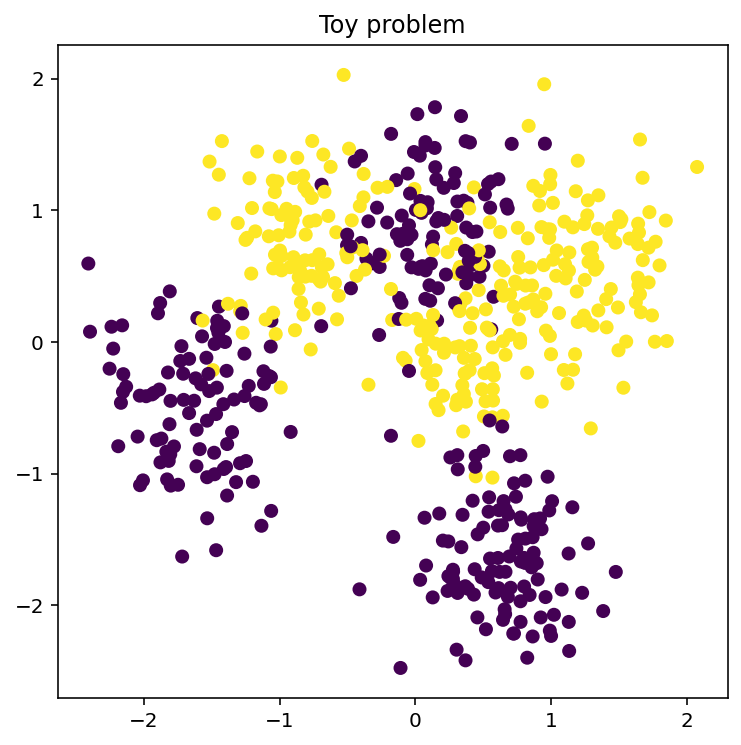

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
n_samples = 1000
random_state = 170
X, y = make_blobs(n_samples=n_samples, centers=6,cluster_std = 2, random_state=random_state)
# Convert to binary
y[y==2]=0
y[y==3]=0
y[y==4]=1
y[y==5]=1

# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.title("Toy problem")
plt.show()

## Creando nuestro conjunto por Bagging

Comencemos creando un conjunto de clasificadores por Bagging, para ello consideremos que los clasificadores base son árboles de decisión.



### Paso 1: Submuestreo

Entrenemos varios árboles de decisión con versiones submuestreadas de los datos de entrenamiento 

In [40]:
# Some utility functions

def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

Accuracy tree 0: 0.84
Accuracy tree 1: 0.86
Accuracy tree 2: 0.75
Accuracy tree 3: 0.78
Accuracy tree 4: 0.77
Accuracy tree 5: 0.77
Accuracy tree 6: 0.75
Accuracy tree 7: 0.81
Accuracy tree 8: 0.80
Accuracy tree 9: 0.72


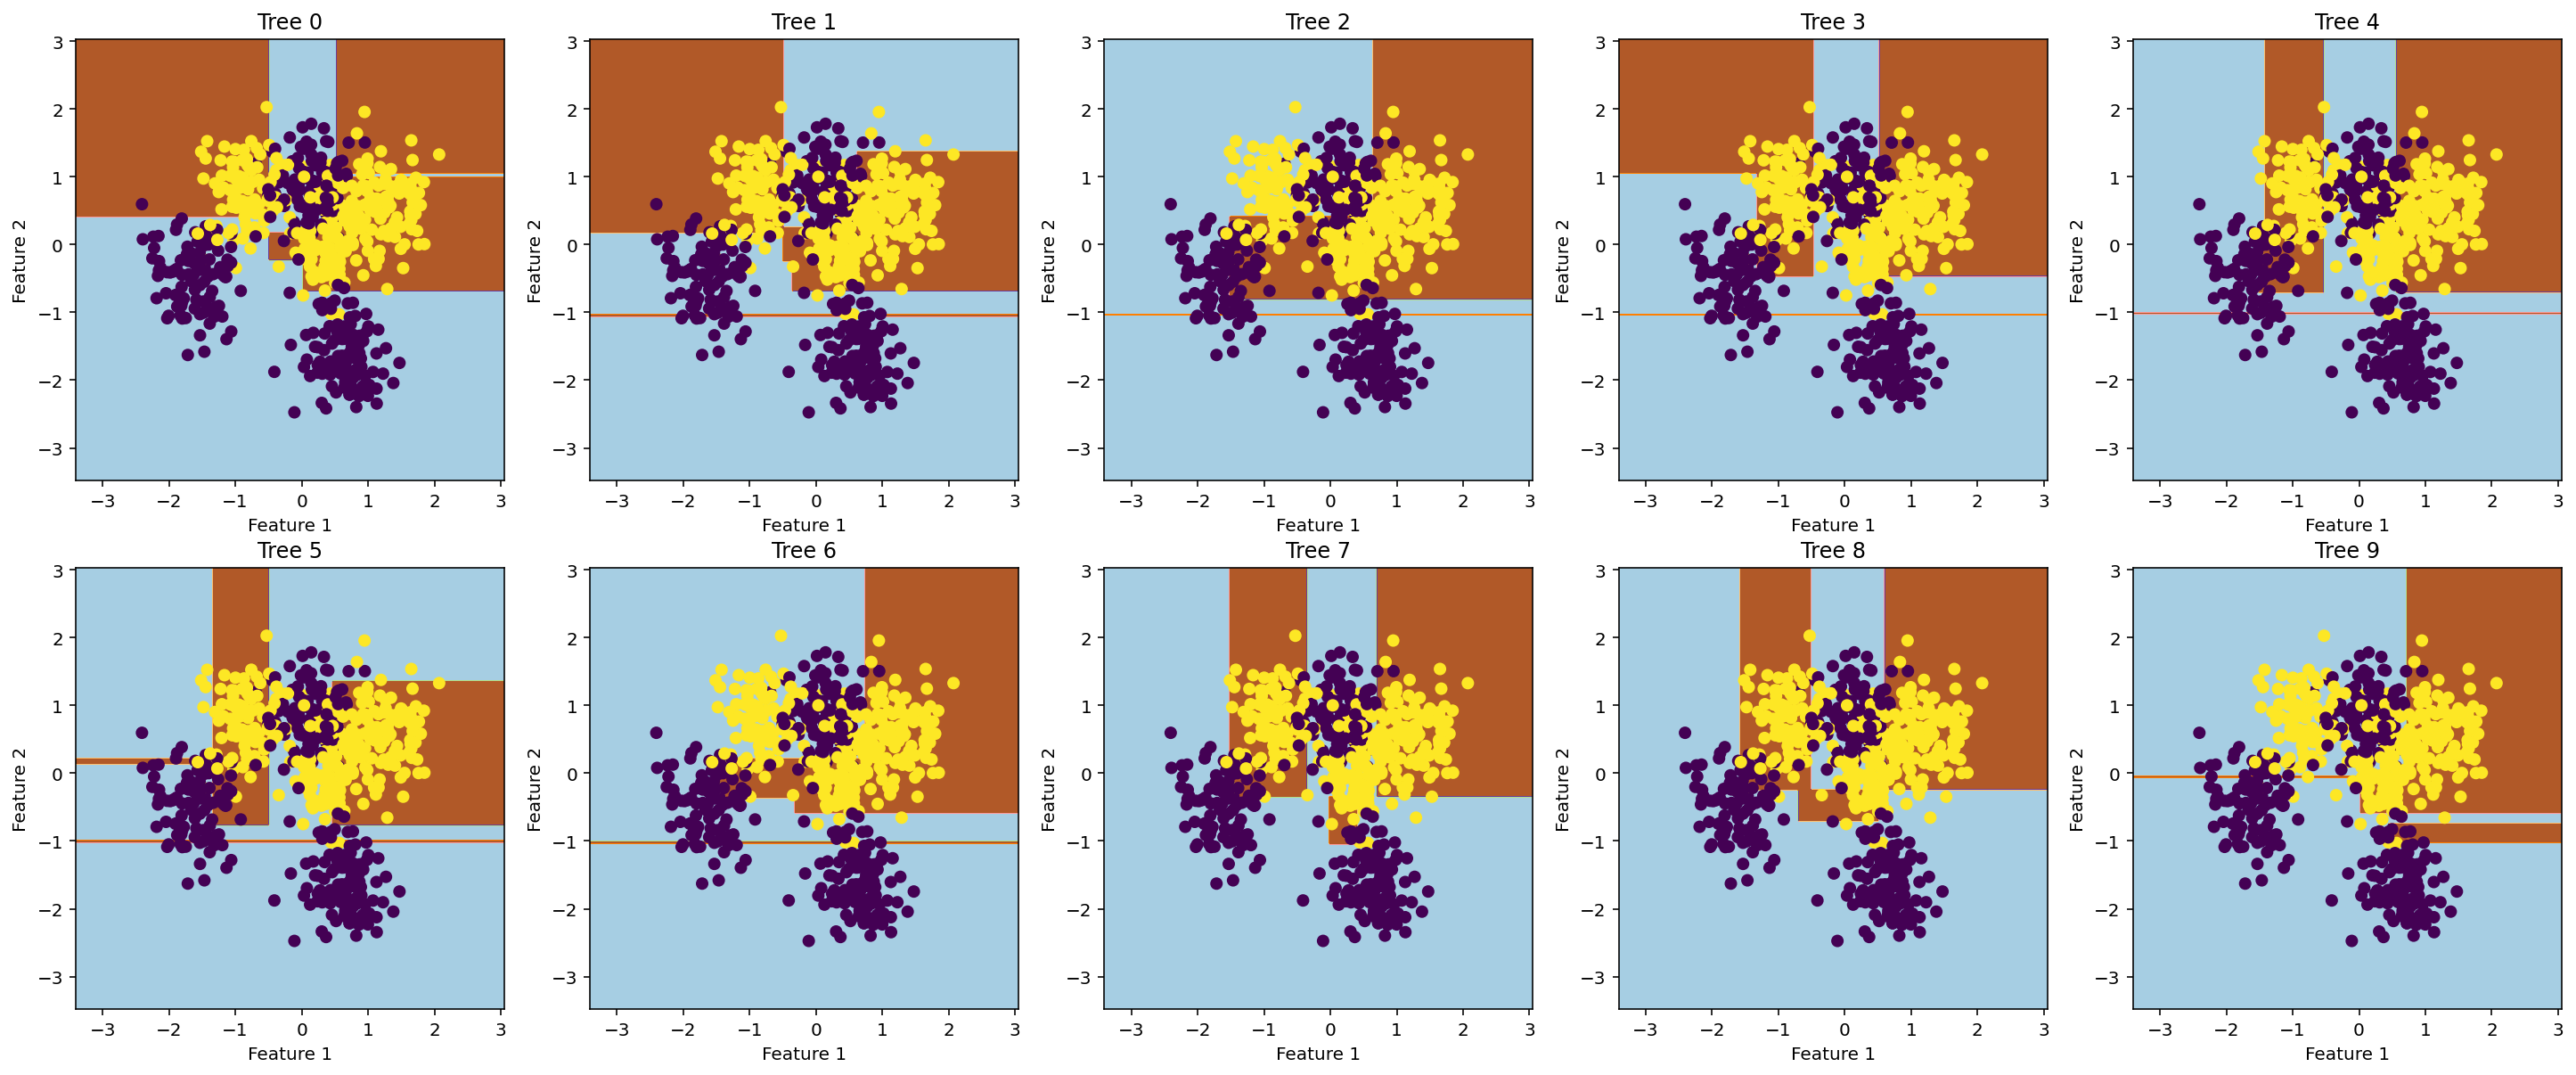

In [41]:
from sklearn import tree
import copy

# Some parameters
max_depth = 4
T =10
nperc = 0.4
N = X_train.shape[0]
Ntest = X_test.shape[0]
Nsub = np.int(nperc*N)

# Define the base classifier
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
ensemble_clf = []
o_train = np.zeros((T,N))
o_test = np.zeros((T,Ntest))
 
plt.figure(figsize=(25,10))
np.random.seed(0)

# Repeat this T times....
for t in range(T):
  # Subsampling with replacement
  samples_bag = np.random.choice(N, Nsub, replace=True)
  X_train_sub  = X_train[samples_bag,:]
  Y_train_sub  = Y_train[samples_bag]

  # Train a bagged tree
  clf_tree.fit(X_train_sub, Y_train_sub)
  ensemble_clf.append(copy.copy(clf_tree))
  
  # Get and save soft-output
  o_train[t,:] = clf_tree.predict_proba(X_train)[:,1]
  o_test[t,:] = clf_tree.predict_proba(X_test)[:,1]

  # Compute test predictions
  acc = clf_tree.score(X_test, Y_test)
  print('Accuracy tree %d: %2.2f'%(t, acc))
  
  # Plot the solution
  plt.subplot(2,5,t+1)
  plot_boundary(clf_tree, X_train, Y_train, plt)
  plt.title('Tree '+str(t))

plt.show()

### Paso 2: Combinando las salidas

En problemas de clasificación podemos encontrarnos dos aproximaciones para obtener la salida final del conjunto:

1. **Calculando la moda de las salidas de los clasificadores base**

Cuando trabajamos con problemas de clasificación, es bastante común obtener la salida de conjunto como la salida más frecuente. Con este esquema, se considera que la salida de cada clasificador base es un voto y se calcula la salida final del conjunto como el voto mayoritario.


2. **Calculando el promedio de las salidas de los clasificadores base**

Otra opción consiste en aprovechar los resultados de los clasificadores para calcular la predicción final como un promedio de todas las predicciones de los clasificadores base. Esta opción también se utiliza en los problemas de clasificación, pero es el enfoque típico para los problemas de regresión.



In [42]:
# Solution computing the ensemble output with the mode
from scipy import stats
from sklearn.metrics import accuracy_score
# Use the values saved in o_train and o_test

# Convert soft-output to target values
o_train_pred = np.where(o_train > 0.5, 1, 0)
o_test_pred = np.where(o_test > 0.5, 1, 0)

# Compute the mode
f_train_pred = np.squeeze(stats.mode(o_train_pred, axis=0)[0])
f_test_pred = np.squeeze(stats.mode(o_test_pred, axis=0)[0])

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.82


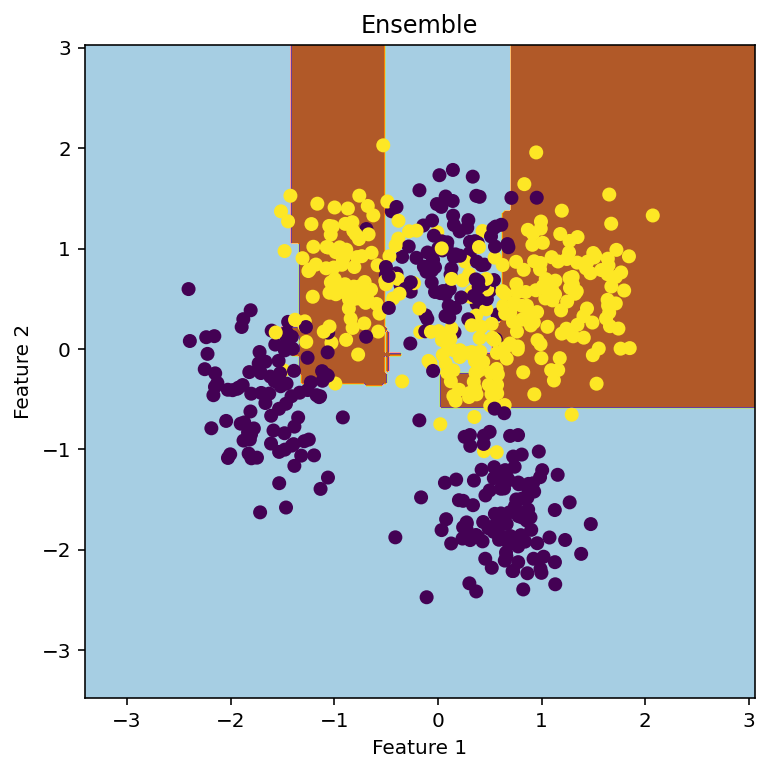

In [43]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      
    Z_ens_pred = np.squeeze(stats.mode(Z, axis=0)[0])

    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train, Y_train, plt)
plt.title('Ensemble')
plt.show()

In [44]:
# Solution computing the ensemble output with the mean
# Use the values saved in o_train and o_test

# Convert soft-output to target values
o_train_pred = np.where(o_train > 0.5, 1, 0)
o_test_pred = np.where(o_test > 0.5, 1, 0)

# Compute the mode
f_train_pred = np.where(np.mean(o_train, axis=0) > 0.5, 1, 0)
f_test_pred = np.where(np.mean(o_test, axis=0) > 0.5, 1, 0)

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.86


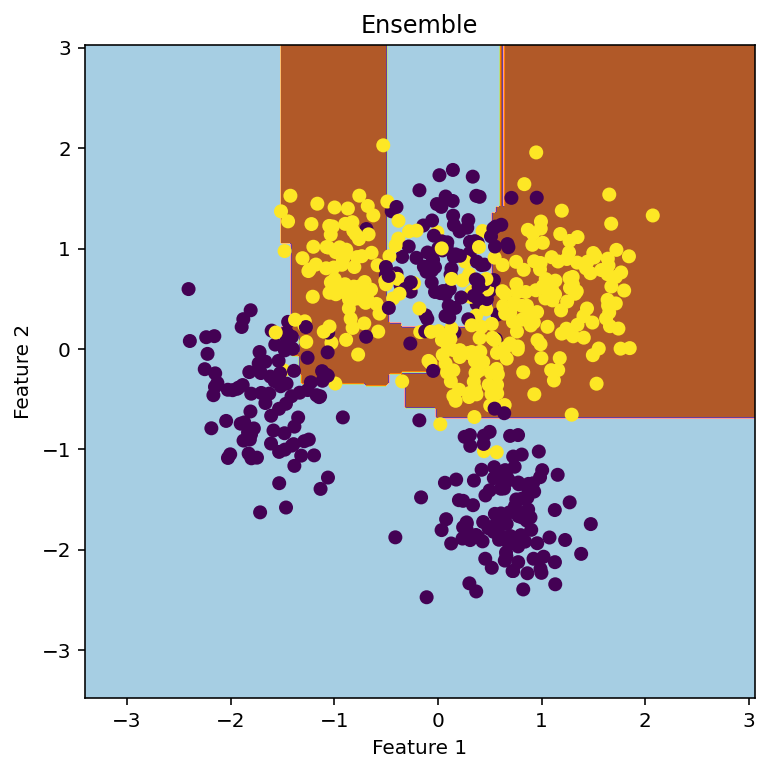

In [45]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    Z_ens_pred = np.where(np.mean(Z, axis=0) > 0.5, 1, 0)
    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train, Y_train, plt)
plt.title('Ensemble')
plt.show()

## Modelos de Bagging en sklearn

Los modelos de Bagging pueden entrenarse fácilmente en sklearn usando la clase [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) que permite definir un clasificador base junto con diferentes parámetros para definir la estrategia exacta para la generación de subconjuntos de datos de entrenamiento. 



### Ejercicio 1

Utiliza el modelo `BaggingClassifier` de sklearn para entrenar un conjunto de T árboles con una tasa de submuestreo del 40% (`nperc = 0.4`). Para este ejercicio, considere que cada árbol tiene una profundidad máxima de 4 y utilice los valores predeterminados para el resto de los parámetros.

Compare los resultados con los de nuestra implementación anterior.


#### Solución

In [46]:
from sklearn.ensemble import BaggingClassifier
max_depth = 4
T =10
nperc = 0.4
#<SOL>
clf = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=T, max_samples=nperc).fit(X_train, Y_train)
acc_ens = clf.score(X_test, Y_test)
print('Ensemble accuracy: %2.2f'%(acc_ens))
#</SOL>

Ensemble accuracy: 0.88


## Profundizando en el funcionamiento de los modelos de Bagging 

Vamos  utilizar la librería de sklearn para ver como evoluciona el error según añadimos árboles al conjunto.

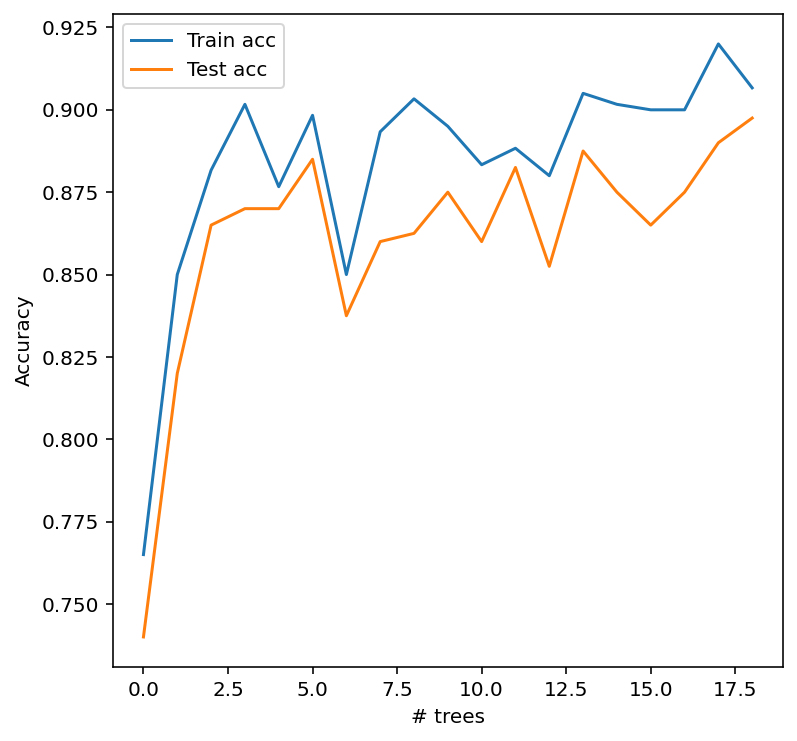

In [47]:
T=20
n_perc = 0.4
bagg1_acc_tr=[]
bagg1_acc_test=[]
for t in range(1,T):
  clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=t, max_samples=n_perc).fit(X_train, Y_train)
  bagg1_acc_tr.append(clf1.score(X_train, Y_train))
  bagg1_acc_test.append(clf1.score(X_test, Y_test))

plt.figure()
plt.plot(bagg1_acc_tr, label='Train acc')
plt.plot(bagg1_acc_test, label='Test acc')

plt.legend()
plt.xlabel('# trees')
plt.ylabel('Accuracy')

plt.show()

Y si repetimos ahora el experimento....

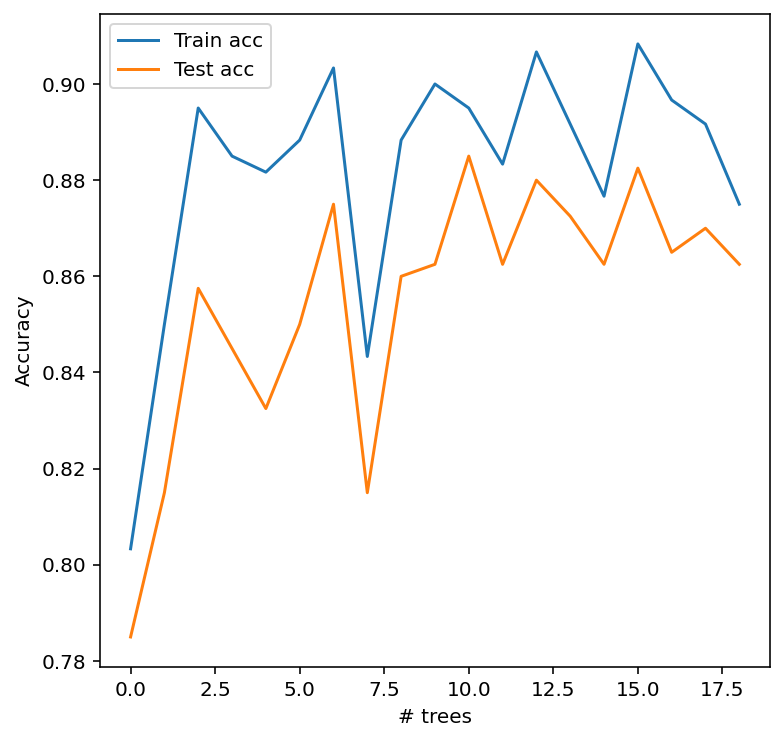

In [48]:
T=20
n_perc = 0.4
bagg1_acc_tr=[]
bagg1_acc_test=[]
for t in range(1,T):
  clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=t, max_samples=n_perc).fit(X_train, Y_train)
  bagg1_acc_tr.append(clf1.score(X_train, Y_train))
  bagg1_acc_test.append(clf1.score(X_test, Y_test))

plt.figure()
plt.plot(bagg1_acc_tr, label='Train acc')
plt.plot(bagg1_acc_test, label='Test acc')

plt.legend()
plt.xlabel('# trees')
plt.ylabel('Accuracy')

plt.show()

Aunque el error final tiende a ser el mismo, vemos que las curvas son muy ruidosas y hay muchas diferencias entre ellas (principalmente, al principio). Vamos a repetir este experimento varias veces y promediar los resultados...

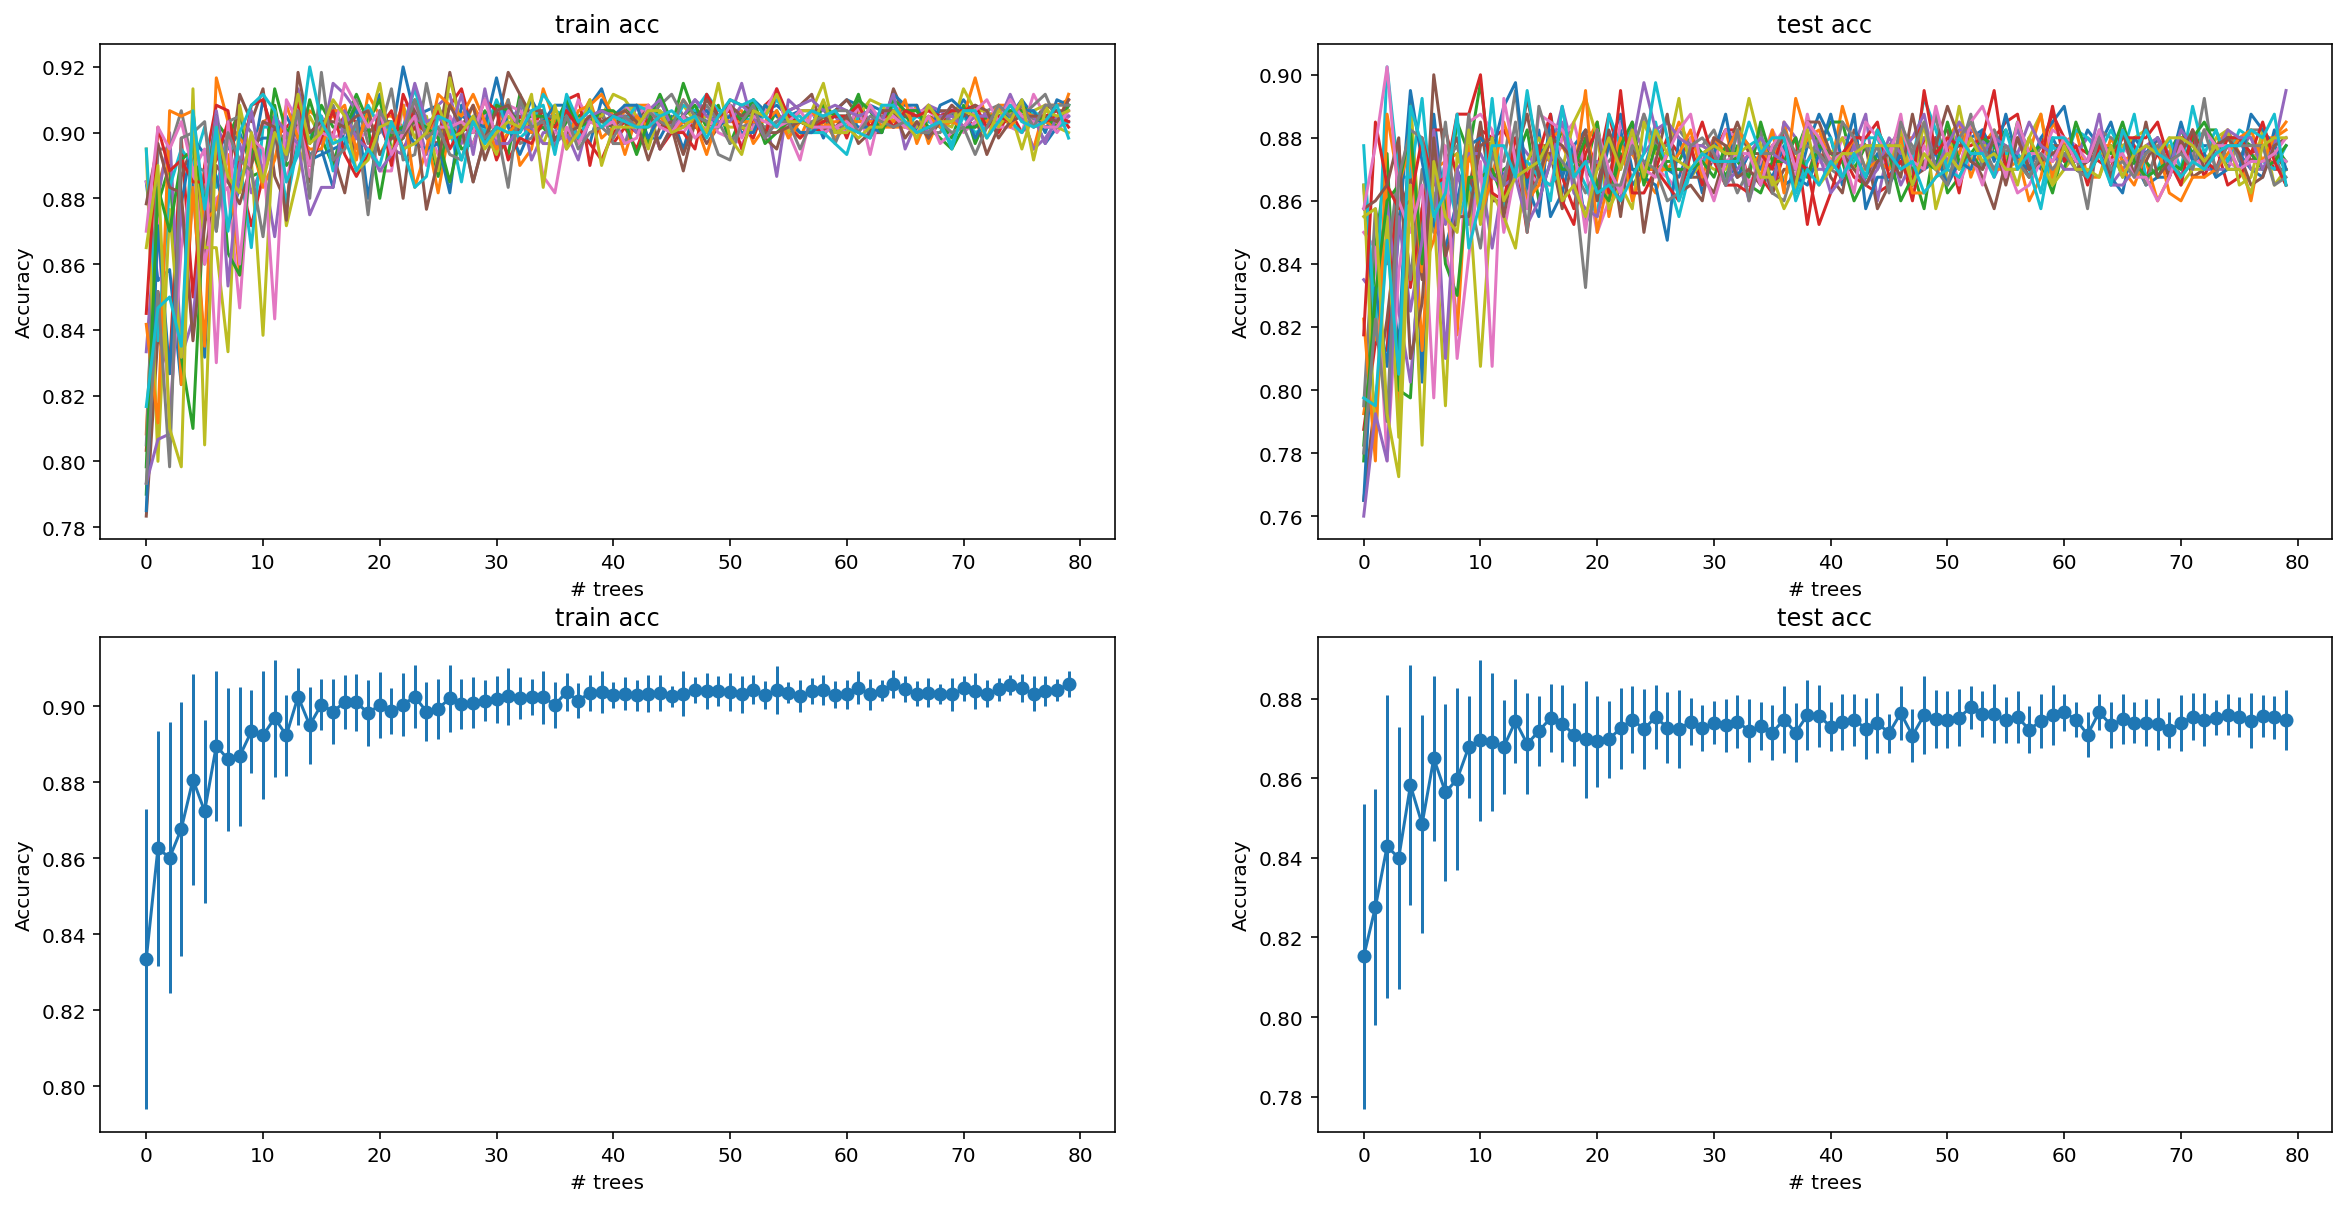

In [49]:
T=80
n_perc = 0.4
niter = 20

bagg1_acc_tr_iter=[]
bagg1_acc_test_iter=[]
for n in range(niter):
  bagg1_acc_tr=[]
  bagg1_acc_test=[]
  for t in range(1,T+1):
    clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=t, max_samples=n_perc).fit(X_train, Y_train)
    bagg1_acc_tr.append(clf1.score(X_train, Y_train))
    bagg1_acc_test.append(clf1.score(X_test, Y_test))
  bagg1_acc_tr_iter.append(bagg1_acc_tr)
  bagg1_acc_test_iter.append(bagg1_acc_test)


bagg1_acc_tr_iter = np.array(bagg1_acc_tr_iter)
bagg1_acc_test_iter= np.array(bagg1_acc_test_iter)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(bagg1_acc_tr_iter.T, label='Train acc')
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title('train acc')

plt.subplot(2,2,2)
plt.plot(bagg1_acc_test_iter.T, label='Test acc')
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title('test acc')


plt.subplot(2,2,3)
plt.errorbar(np.arange(T),np.mean(bagg1_acc_tr_iter, axis=0), np.std(bagg1_acc_tr_iter, axis=0), fmt='-o')
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title('train acc')

plt.subplot(2,2,4)
plt.errorbar(np.arange(T),np.mean(bagg1_acc_test_iter, axis=0), np.std(bagg1_acc_test_iter, axis=0), fmt='-o')
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title('test acc')

plt.show()

Viendo las curvas promedio (y su varianza) vemos cosas muy interesantes:
* Cada árbol utiliza particiones muy diferentes de los datos, proporcionando soluciones muy dispares (esto lo vemos cuando hay pocos árboles en el conjunto). 

* Ésta es justamente la **diversidad** entre sus salidas que vamos a aprovechar en la combinación.

* Según se añaden árboles (y promediamos sus salidas), las prestaciones del modelo se vuelven más estables. Al combinar muchos modelos conseguimos **reducir la varianza del error** obteniendo unas mejores prestaciones.

* Simplemente, por el hecho de combinar modelos, conseguimos tener un **modelo más estable**.

* Además, este método no corre peliro de sobreajustar, podemos añadir todos los clasificadores que queramos al conjunto sin correr peligro de sobreentrenar.


## Influencia del parámetro `n_perc`

Hasta ahora, hemos usado el 40% de los datos para entrenar cada clasificador base. Uno podría pensar, que si usamos más muestras, mejoraríamos las prestaciones de estos clasificadores base y, por tanto, las prestaciones del conjunto final. Sin embargo, esto no garantiza la mejora de los resultados. 

En los modelos de Bagging siempre hay un compromiso entre las prestaciones del clasificador base y la ganancia que se obtiene en el conjunto. El usar más muestras para entrenar puede aportar ventajas al conjunto si los clasificadores base son muy malos, pero si estos modelos ya funcionan bastante bien, son muy estables y sus salidas son muy parecidas (no hay diversidad), la mejora aportada por el conjunto se reduce...

Para analizar esto vamos a entrenar diferentes conjuntos con diferentes valores de `n_perc` y analizar las prestaciones...

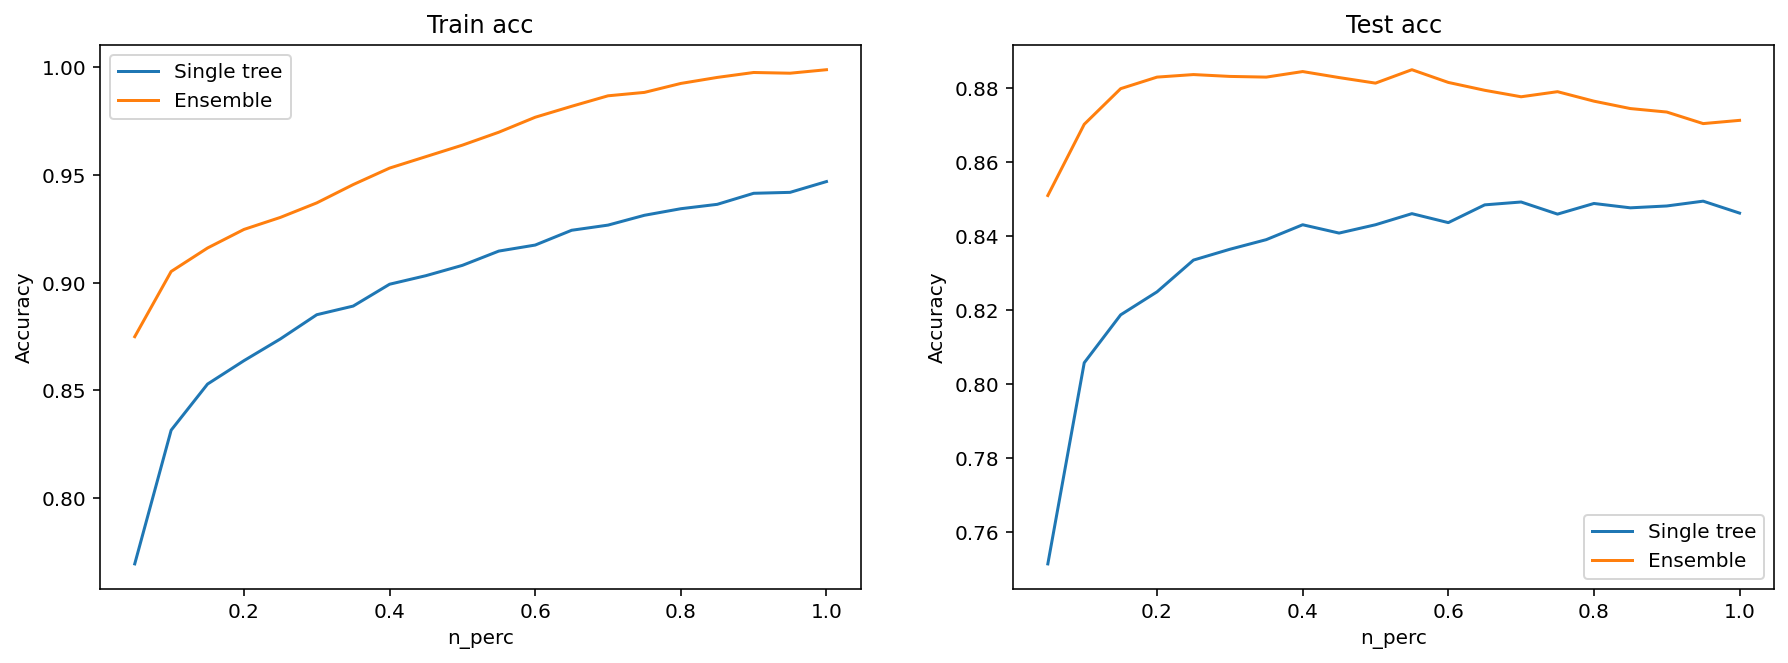

In [50]:
T=40
range_perc = np.arange(0.05, 1.01, 0.05)
# First, let's train a single tree for comparison purposes

N = X_train.shape[0]
tree_acc_tr_all=[]
tree_acc_test_all=[]
for n in range(100):
  tree_acc_tr=[]
  tree_acc_test=[]
  for n_perc in range_perc:
    # Subsampling with replacement
    Nsub = np.int(n_perc*N)
    samples_bag = np.random.choice(N, Nsub, replace=True)
    X_train_sub  = X_train[samples_bag,:]
    Y_train_sub  = Y_train[samples_bag]
    # Train a tree
    clf_tree = tree.DecisionTreeClassifier().fit(X_train_sub, Y_train_sub )
    tree_acc_tr.append(clf_tree.score(X_train, Y_train))
    tree_acc_test.append(clf_tree.score(X_test, Y_test))
  tree_acc_tr_all.append(tree_acc_tr)
  tree_acc_test_all.append(tree_acc_test)

tree_acc_tr_all = np.array(tree_acc_tr_all)
tree_acc_test_all= np.array(tree_acc_test_all)


# Now, let's train our ensemble
bagg1_acc_tr_iter=[]
bagg1_acc_test_iter=[]
for n in range(40):
  bagg1_acc_tr=[]
  bagg1_acc_test=[]
  for n_perc in range_perc:
    clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(), n_estimators=T, max_samples=n_perc).fit(X_train, Y_train)
    bagg1_acc_tr.append(clf1.score(X_train, Y_train))
    bagg1_acc_test.append(clf1.score(X_test, Y_test))
  bagg1_acc_tr_iter.append(bagg1_acc_tr)
  bagg1_acc_test_iter.append(bagg1_acc_test)


bagg1_acc_tr_iter = np.array(bagg1_acc_tr_iter)
bagg1_acc_test_iter= np.array(bagg1_acc_test_iter)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_perc, np.mean(tree_acc_tr_all,axis=0), label='Single tree')
plt.plot(range_perc, np.mean(bagg1_acc_tr_iter,axis=0), label='Ensemble')
plt.xlabel('n_perc')
plt.ylabel('Accuracy')
plt.title('Train acc')
plt.legend()

plt.subplot(1,2,2)

plt.plot(range_perc, np.mean(tree_acc_test_all,axis=0), label='Single tree')
plt.plot(range_perc, np.mean(bagg1_acc_test_iter,axis=0), label='Ensemble')
plt.xlabel('n_perc')
plt.ylabel('Accuracy')
plt.title('Test acc')
plt.legend()

plt.show()


Este efecto viene generado por lo que se conoce como **diversidad**, si queremos que el conjunto sea capaz de mejorar las prestaciones de los clasificadores base, necesitamos que haya diversidad entre ellos, es decir, que proporcionen salidas diferentes. Si tenemos árboles muy parecidos (con salidas muy similares), el conjunto no es capaz de mejorar la salida final combinando salidas similares, simplemente, dará más de lo mismo.

Veamos esto calculando la diversidad entre los árboles. Para ello vamos a calcular la diverdad como $1-\rho$, siendo $\rho$ la correlación entre sus salidas.

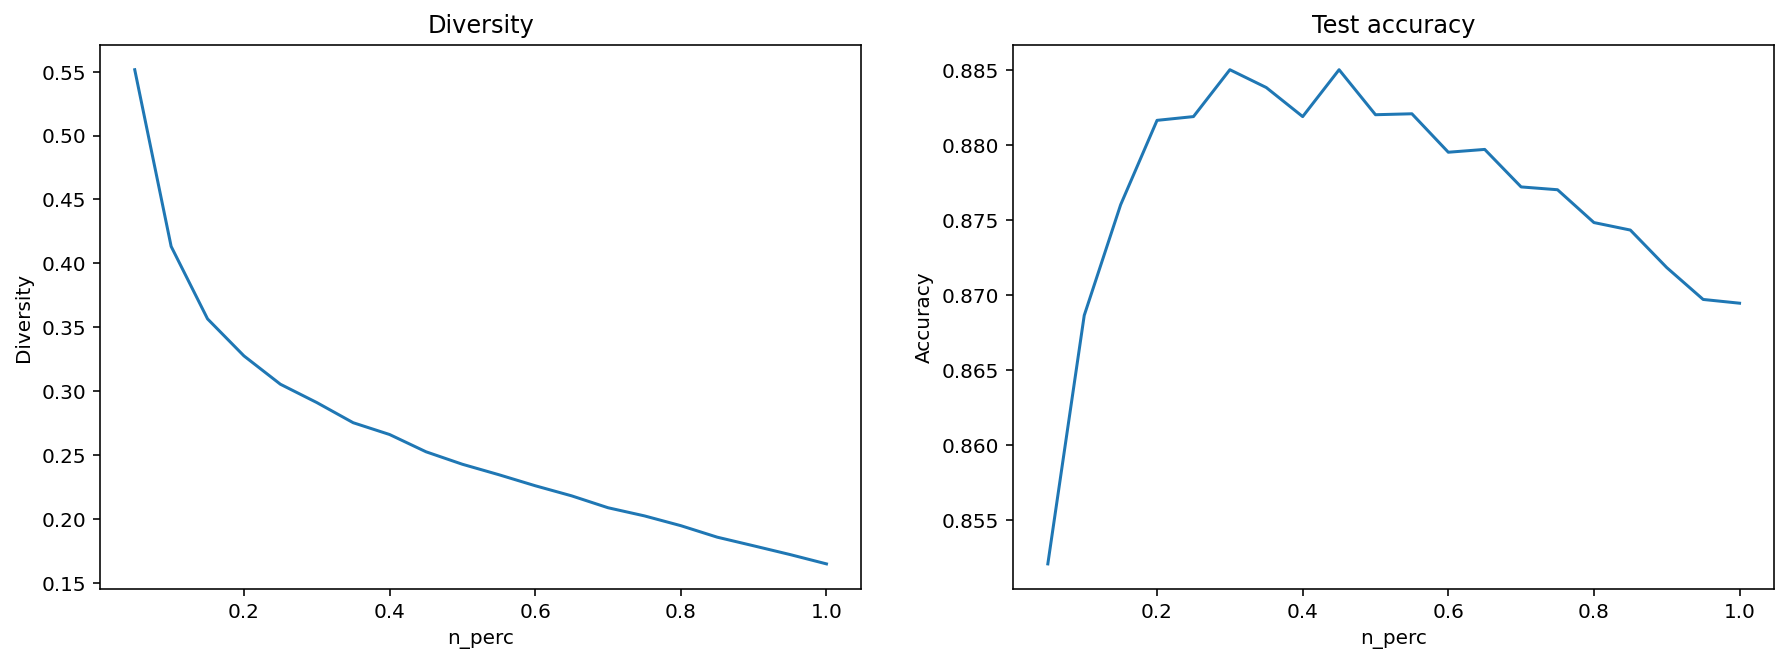

In [51]:
T=40
range_perc = np.arange(0.05, 1.01, 0.05)

# Now, let's train our ensemble
bagg1_acc_tr_iter=[]
bagg1_acc_test_iter=[]
Diversity_iter=[]
for n in range(40):
  bagg1_acc_tr=[]
  bagg1_acc_test=[]
  Diversity=[]
  for n_perc in range_perc:
    clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(), n_estimators=T, max_samples=n_perc).fit(X_train, Y_train)
    bagg1_acc_tr.append(clf1.score(X_train, Y_train))
    bagg1_acc_test.append(clf1.score(X_test, Y_test))
    f_train = np.zeros((T,X_train.shape[0]))
    for t in range(T):
      f_train[t,:] = clf1.estimators_[t].predict_proba(X_train)[:,0]
 
    Matrix_corr = np.corrcoef(f_train)
    corrValues = np.triu(Matrix_corr, k=1)
    corrValues = corrValues[np.nonzero(corrValues)] 
    Diversity.append(1-np.abs(np.mean(corrValues)))
  bagg1_acc_tr_iter.append(bagg1_acc_tr)
  bagg1_acc_test_iter.append(bagg1_acc_test)
  Diversity_iter.append(Diversity)

bagg1_acc_tr_iter = np.array(bagg1_acc_tr_iter)
bagg1_acc_test_iter = np.array(bagg1_acc_test_iter)
Diversity_iter = np.array(Diversity_iter)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_perc, np.mean(Diversity_iter,axis=0))
plt.xlabel('n_perc')
plt.ylabel('Diversity')
plt.title('Diversity')

plt.subplot(1,2,2)
plt.plot(range_perc, np.mean(bagg1_acc_test_iter,axis=0))
plt.xlabel('n_perc')
plt.ylabel('Accuracy')
plt.title('Test accuracy')

plt.show()



## ¿Podemos aumentar la diversidad con otros esquemas?

Una manera muy sencilla de aumentar la diversidad es hacer selección de muestras y de características al mismo tiempo (submuestrear la matriz de datos de entrenamiento por filas y por columnas). Para ello, la clase `BaggingClassifier` al igual que tiene el parámetro `max_samples` para indicar el número o porcentaje de muestras de entrenamiento a usar, tiene otro parámetro `max_features` que permite controlar el número o porcentaje de variables que se usan.

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/ensembles/Bagging2.png" width=60%>

A continuación vamos a generar otro problema de juguete con más variables de entrada y analizar la influencia de submuestrear por features.


In [52]:
from sklearn.datasets import make_classification
# Generate a binary classification dataset.
X, y = make_classification(n_samples=1000, n_features=25,
                           n_clusters_per_class=1, n_informative=20,
                           random_state=0)
# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

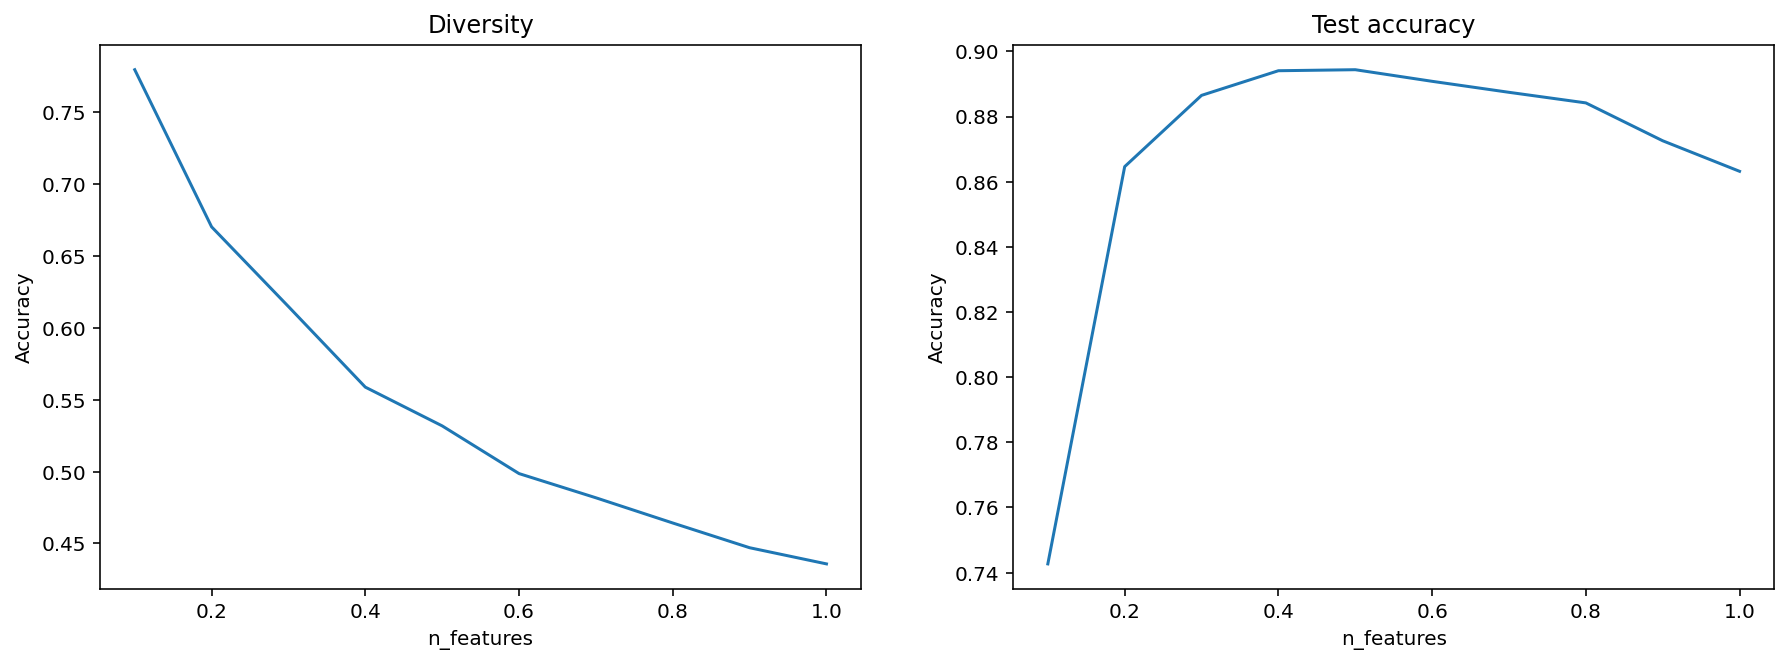

In [53]:
T=40
range_feat = np.arange(0.1, 1.01, 0.1)
n_perc = 0.5
# Now, let's train our ensemble
bagg1_acc_tr_iter=[]
bagg1_acc_test_iter=[]
Diversity_iter=[]
for n in range(40):
  bagg1_acc_tr=[]
  bagg1_acc_test=[]
  Diversity=[]
  for n_feat in range_feat:
    clf1 = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(), n_estimators=T, max_samples=n_perc, max_features=n_feat).fit(X_train, Y_train)
    bagg1_acc_tr.append(clf1.score(X_train, Y_train))
    bagg1_acc_test.append(clf1.score(X_test, Y_test))
    f_train = np.zeros((T,X_train.shape[0]))
    for t in range(T):
      # Here, we have to  use the infromation about the selected feature
      f_train[t,:] = clf1.estimators_[t].predict_proba(X_train[:,clf1.estimators_features_[t]])[:,0]
 
    Matrix_corr = np.corrcoef(f_train)
    corrValues = np.triu(Matrix_corr, k=1)
    corrValues = corrValues[np.nonzero(corrValues)] 
    Diversity.append(1-np.abs(np.mean(corrValues)))
  bagg1_acc_tr_iter.append(bagg1_acc_tr)
  bagg1_acc_test_iter.append(bagg1_acc_test)
  Diversity_iter.append(Diversity)

bagg1_acc_tr_iter = np.array(bagg1_acc_tr_iter)
bagg1_acc_test_iter = np.array(bagg1_acc_test_iter)
Diversity_iter = np.array(Diversity_iter)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_feat, np.mean(Diversity_iter,axis=0))
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.title('Diversity')

plt.subplot(1,2,2)
plt.plot(range_feat, np.mean(bagg1_acc_test_iter,axis=0))
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.title('Test accuracy')

plt.show()

Además, sklearn también incluye dos métodos específicos para diseñar conjuntos por bagging, con diversidad adicional, cuando los clasificadores base son árboles de decisión:
* **[Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)**. Como ya sabemos los RF no son más que un conjunto de árboles donde cada árbol se entrena con un subconjunto de datos de entrenameinto y un subconjunto de características.
* **[Extremely Randomized Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)**. En este caso la diversidad se aumenta con los umbrales de decisión y no con las características, ya que este conjunto funciona como un Bagging de árboles de decisión normal, pero cada árbol, en lugar de buscar los umbrales más discriminantes, fuerza una diversidad adicional mediante el uso de umbrales aleatorios. Es decir, cada vez que analiza una variable candidata, no busca el mejor umbral sino que lo fija aleatoriamente y el mejor de estos pares variable-umbral se elige como la regla de división.


### Ejercicio 2
Compare las prestaciones del esquema de Bagging normal, como el del Ejercicio 1, frente a las prestaciones de un RF y un ERT. Utilice 40 árboles con una profundidad máxima de 4 y un 40% de muestras de entrenamiento y 50% de características para el RF.


#### Solution

In [54]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

max_depth = 4
T =40
n_perc = 0.4
n_feat = 0.5
#<SOL>
clf = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=T, max_samples=n_perc).fit(X_train, Y_train)
acc_ens = clf.score(X_test, Y_test)
print('Bagging Ensemble accuracy: %2.2f'%(acc_ens))

clf_RF  = RandomForestClassifier(n_estimators=T, max_depth=4, max_samples=nperc, max_features=n_feat).fit(X_train, Y_train)
acc_RF = clf_RF.score(X_test, Y_test)
print('RF accuracy: %2.2f'%(acc_RF))

clf_ETC  = ExtraTreesClassifier(n_estimators=T, max_depth=4, max_samples=nperc).fit(X_train, Y_train)
acc_ETC = clf_ETC.score(X_test, Y_test)
print('ETC accuracy: %2.2f'%(acc_ETC))
#</SOL>

Bagging Ensemble accuracy: 0.81
RF accuracy: 0.87
ETC accuracy: 0.88


##Ventajas adicionales de los modelos de Bagging





**1. Estimación Out-of-bag (OOB)**

Como sabemos, para el entrenamiento de cada clasificador sólo utilizamos un subconjunto de muestras, por lo que en la práctica cada muestra de entrenamiento sólo participa en el entrenamiento de algunos clasificadores. Podemos utilizar esto para obtener una estimación del error de esta muestra clasificándola con el conjunto de clasificadores en los que no ha participado. Si hacemos esto con todas las muestras y promediamos estos errores, obtenemos lo que se conoce como "out-of-bag (OOB) estimation". 

Veamos como podemos utilizar el OOB para seleccionar el número óptimo de datos y características a utilizar en el submuestreo de un RF.




Optimum number of features: 30
Optimum number of data: 30


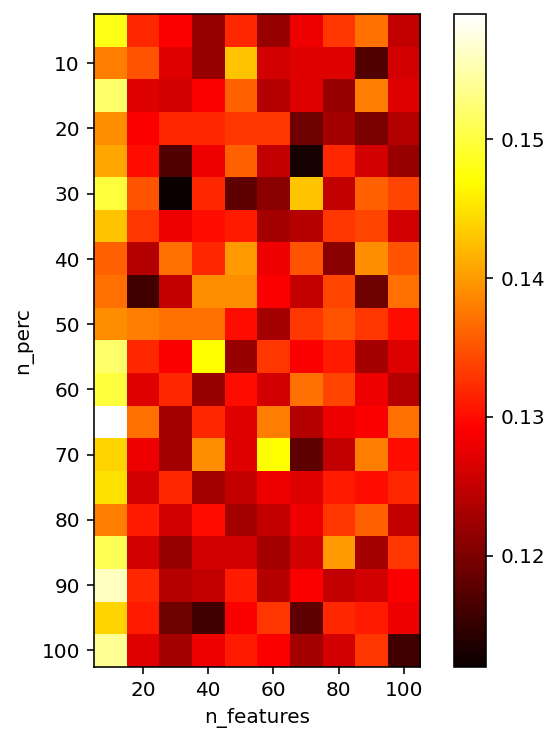

In [55]:
range_feat = np.arange(0.1, 1.01, 0.1)
range_perc = np.arange(0.05, 1.01, 0.05)

clf = RandomForestClassifier(n_estimators=T, oob_score=True, max_depth=4)

error_oob_all = []
for n_perc in range_perc:
  clf.set_params(max_samples=nperc)
  error_oob = []
  for n_feat in range_feat:
    clf.set_params(max_features=n_feat)
    clf.fit(X, y)
    # Record the OOB error for each `n_estimators=i` setting.
    error_oob.append(1 - clf.oob_score_)
  error_oob_all.append(error_oob)     

error_oob_all = np.array(error_oob_all)

# Plot OOB
fig, ax = plt.subplots(1,1)
img= ax.imshow(error_oob_all , cmap=plt.cm.hot)
ax.set_xlabel('n_features')
ax.set_ylabel('n_perc')
pos_x = [1, 3, 5, 7, 9]
ax.set_xticks(pos_x )
ax.set_xticklabels((100*range_feat[pos_x]).astype(np.int))
pos_y = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
ax.set_yticks(pos_y )
ax.set_yticklabels((100*range_perc[pos_y]).astype(np.int))
fig.colorbar(img)
fig.show()

# select optimum values
ind = np.unravel_index(np.argmin(error_oob_all, axis=None), error_oob_all.shape)
feat_opt=range_feat[ind[1]]
perc_opt=range_perc[ind[0]]
print('Optimum number of features: %d'%(100*feat_opt))
print('Optimum number of data: %d' %(100*perc_opt))

**2. Importancia de las características de entrada**

Cuando usamos árboles como clasificadores base del conjunto, podemos evaluar la importancia de las características en una tarea de clasificación. Si tenemos en cuenta que la utilización de una variable de entrada por un árbol y su  profundidad nos proporciona una importancia relativa de esa característica, analizando esta información sobre todos los árboles del conjunto, podemos obtener una buena estimación de la importancia de cada característica. Podríamos, incluso, utilizar esta información para hacer selección de características. 



Tanto `RandomForestClassifier()` como `ExtraTreesClassifier()` son capaces de aprender durante su entrenamiento las **relevancias de las características**. Analicemos para el ejemplo anterior cuáles son las variables más importantes; nótese que cuando generamos los datos indicamos que solo 20 de las 25 variables eran relevantes.

RF accuracy: 0.85
Feature ranking:
1. feature 2 (0.206339)
2. feature 23 (0.093133)
3. feature 11 (0.085836)
4. feature 8 (0.078200)
5. feature 14 (0.071903)
6. feature 20 (0.063384)
7. feature 4 (0.042234)
8. feature 5 (0.041770)
9. feature 21 (0.041170)
10. feature 1 (0.038110)
11. feature 22 (0.036230)
12. feature 15 (0.029905)
13. feature 12 (0.028322)
14. feature 19 (0.024757)
15. feature 17 (0.019465)
16. feature 0 (0.016197)
17. feature 3 (0.015130)
18. feature 7 (0.015108)
19. feature 13 (0.010559)
20. feature 16 (0.009233)
21. feature 6 (0.007973)
22. feature 9 (0.007347)
23. feature 18 (0.006863)
24. feature 24 (0.006282)
25. feature 10 (0.004548)


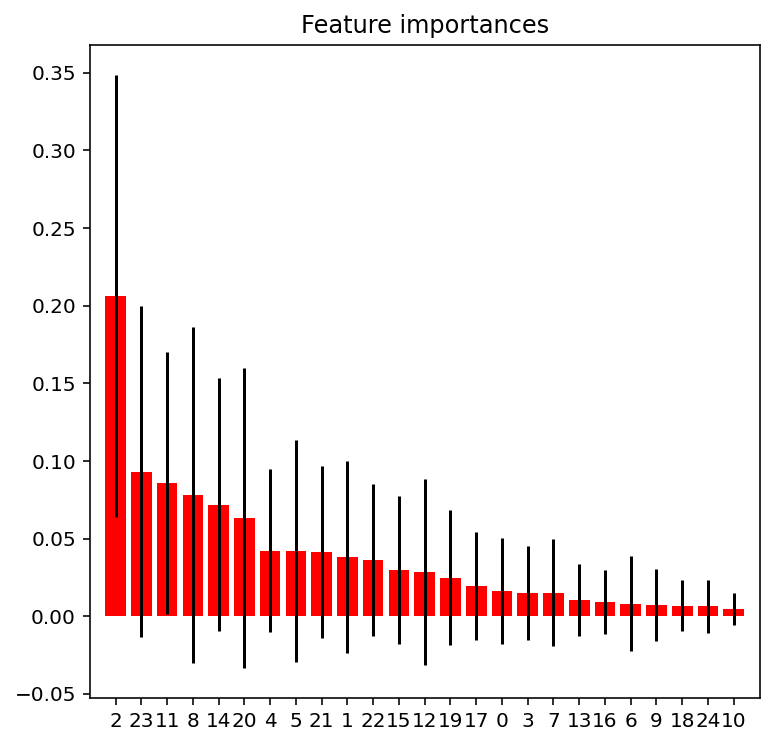

In [56]:
# Train the RF with the OOB selected parameters
clf_RF  = RandomForestClassifier(n_estimators=T, max_depth=4, max_samples=perc_opt, max_features=feat_opt).fit(X_train, Y_train)
acc_RF = clf_RF.score(X_test, Y_test)
print('RF accuracy: %2.2f'%(acc_RF))

importances = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# 3. Boosting: Real Adaboost
Los métodos de Boosting entrenan una secuencia de clasificadores base/débil con versiones ponderadas o enfatizadas de los datos de entrenamiento. Cada uno de estos clasificadores es débil ya que su tasa de error puede ser ligeramente mejor que un clasificador aleatorio. Para obtener el resultado final del conjunto, las salidas de todos estos clasificadores débiles se combinan mediante una combinación ponderada.

El algoritmo de Boosting más popular se llama **AdaBoost** (Adaptive Boosting). Este método de Boosting entrena una secuencia de clasificadores débiles de tal manera que cada nuevo clasificador presta más atención a las muestras mal clasificadas por los clasificadores anteriores. 

Podemos encontrarnos con dos versiones de este algoritmo:
* AdaBoost.M1 o "AdaBoost Discreto" donde las salidas de los clasificadores base son estimaciones discretas de la clase de salida.
* "AdaBoost Real", en este caso, el clasificador base devuelve una predicción de valor real (por ejemplo, una probabilidad asignada al intervalo [-1,1]).

Profundicemos ahora en los principios de funcionamiento del algoritmo **Real AdaBoost**.


**References**

* Schapire, R.E. "The strength of weak learnability". Machine Learning, 5(2): 1651-1686, 1990.

* Freund, Y. and Schapire, R.E. "Experiments with a new boosting algorithm". Proc. of the 13th International Conference on Machine Learning. pp. 148-156, 1996.

* Friedmann, J. H.,  “Stochastic Gradient Boosting”, 2007.


## Real Adaboost
Considere que tenemos un problema de clasificación binaria dado por el conjunto de datos de entrenamiento $S$ que consiste en $N$ pares $(\mathbf{x}^{(i)},y^{(i)})$, donde $\mathbf{x}^{(i)}\in\mathbb{R}^L$ es la observación $i$-ésima e   $y^{(i)}\in\{-1,1\}$  es su etiqueta asociada.

El algoritmo Real Adaboost (RA) entrena secuencialmente un conjunto de  $T$  clasificadores base donde cada clasificador implementa una función de predicción $o_t(x) \in [-1,1]$. Para aprender esta función de predicción cada clasificador observa todo el conjunto de datos de entrenamiento $S$, pero durante su entrenamiento se utiliza una función de énfasis $D_t(\mathbf{x})$ para que el clasificador preste más atención a las muestras más difíciles de clasificar.

Finalmente, la salida final del conjunto se obtiene como una suma ponderada de todos las salidas de los clasificadores base:

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/ensembles/Boosting.png" width=80%>



* **Función de énfasis**:
Para forzar la diversidad entre los clasificadores base, RA pondera (asigna difernetes importancias) a los datos de entrenamiento por medio de una función de énfasis. Inicialmente todos los pesos son iguales:
$$ D_{1}({\bf x}^{(i)}) = \frac{1}{N} $$

para que el primer clasificador sea entrenado de la manera habitual. 

Para las siguientes iteraciones, $t = 2,3,\ldots,T$, la función de énfasis se actualiza con la siguiente regla:
$$ D_{t+1}({\bf x}^{(i)}) = \frac{D_{t}({\bf x}^{(i)}) \exp \left( - \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right)}{Z_t}   $$
  donde $Z_t$ es una constante de normalización que hace que  $\sum_{i=1}^N D_{t+1}({\bf x}^{(i)})  = 1$. 
  
Obsérvese que esta regla de actualización aumenta el peso de énfasis para aquellas observaciones que fueron mal clasificadas por los clasificadores anteriores, mientras que los pesos se reducen para las que fueron clasificadas correctamente. Por lo tanto, a medida que se añaden nuevos alumnos al conjunto, las muestras más erróneas recibirán una mayor atención.

* **Pesos de salida ($\alpha_t$)**
Para obtener los pesos de salida, RA minimiza la función de pérdida exponencial:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$
cuya solución puede obtenerse analíticamente como
$$\alpha_t = \frac{1}{2} \ln \left( \frac{1+\gamma_t}{1-\gamma_t}\right)$$
donde $\gamma_t = \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $. El efecto de estos pesos es dar mayor importancia a los clasificadores que tienen mejores prestaciones dentro del conjunto. 



**Función de coste exponencial**
Esta función de coste es bastante similar a la utilizada por los modelos de regresión logística y es una cota superior del error de clasificación.



In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

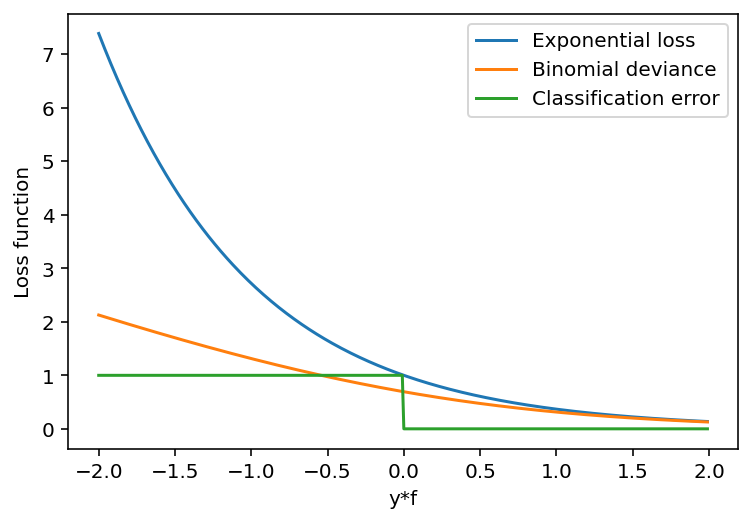

In [58]:
# Plot the exponential loss function (un upper bound of the classfication error)
f = np.arange(-2,2,0.01)
y = 1

l_alpha = np.exp(-y*f)
plt.figure()
plt.plot(y*f,l_alpha, label='Exponential loss')


# Compare with binomial deviance
l_w = np.log(1+ np.exp(f))-y*f
plt.plot(y*f,l_w, label='Binomial deviance')

# Classification error
e_class = np.zeros(f.shape)
e_class[y*f<0] =1
plt.plot(y*f,e_class, label='Classification error')

plt.legend()
plt.xlabel('y*f')
plt.ylabel('Loss function')

plt.show()

## Creemos nuestro conjunto por Boosting (Real Adaboost)

Generemos de nuevo nuestro problema de clasificación bidimensional para ir viendo como construimos un conjunto RA. De nuevo, vamos a considerar como clasificador base un árbol de decisión. 

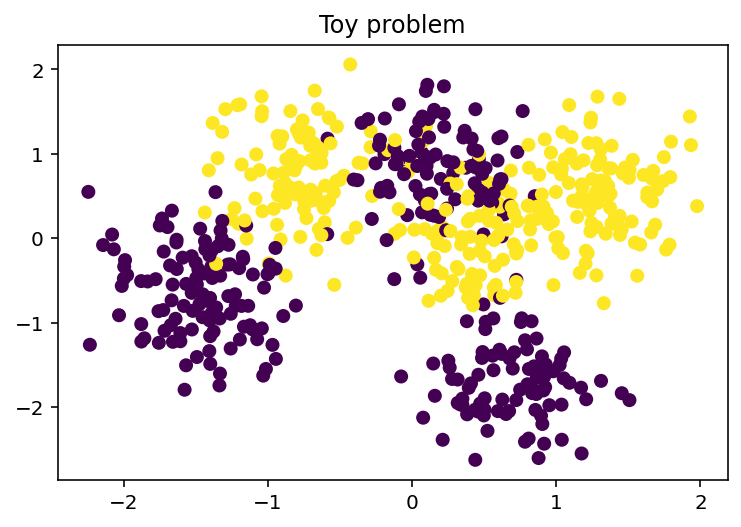

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
n_samples = 1000
random_state = 170
X, y = make_blobs(n_samples=n_samples, centers=6, cluster_std = 2, random_state=random_state)
# Convert to binary
y[y==2]=0
y[y==3]=0
y[y==4]=1
y[y==5]=1

# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.title("Toy problem")
plt.show()

### Paso 1: Entrenamos el primer clasificador

In [60]:
from sklearn import tree
import copy

N = X_train.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,))
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth) 

# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train, Y_train, sample_weight=Dt)
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
  
# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t


Veamos la salida de este clasificador y las muestras más erróneas

In [61]:
def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

In [62]:
def plot_boundaryRA(clf_ens, alpha_ens, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    X=X_train
    Y=Y_train
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = np.zeros((xx.ravel().shape))
    f_t = np.zeros((Y.shape))
    for t, clf in enumerate(clf_ens):
      Z_t = 2*clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]-1
      Z = Z + alpha_ens[t]*Z_t
      o_t = 2*clf.predict_proba(X)[:,1]-1
      f_t = f_t + alpha_ens[t]* o_t
    Z = np.where(Z > 0, 1, 0)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Mark erroneous samples
    # Compute output weights
    error_t =  f_t*(2*Y-1)
    pos_error = np.where(error_t<=0)[0]


    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, label='Training data')
    size=20*np.abs(error_t[pos_error])
    # Plot erroneous data
    plt.scatter(X[pos_error, 0], X[pos_error, 1], c='r', s = size, marker='x', label='Erroneous sample')
    plt.axis("tight")
    plt.legend()

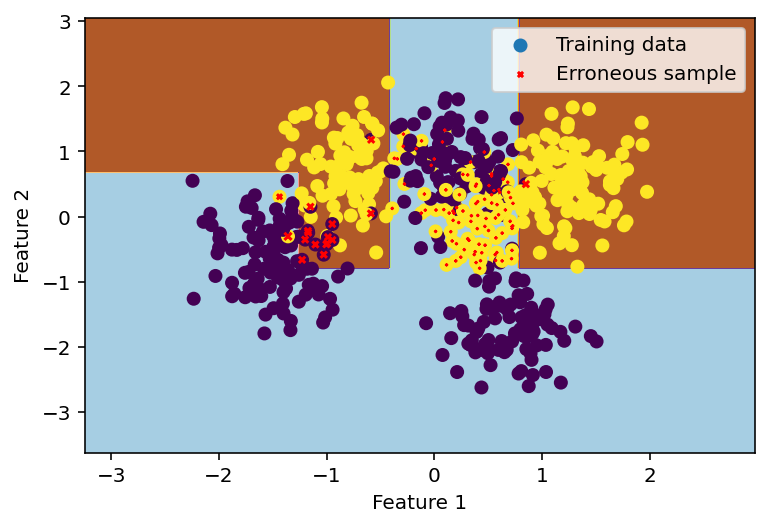

In [63]:
plt.figure()
plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
plt.show()

### Paso 2: Actualizamos la función de énfasis y añadimos otro árbol

In [64]:
# Update emphasis function
Dt = Dt * np.exp(-alpha_t * (o_t*Y_train))
Dt = Dt /np.sum(Dt)
# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train, Y_train, sample_weight=Dt)
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
  
# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t

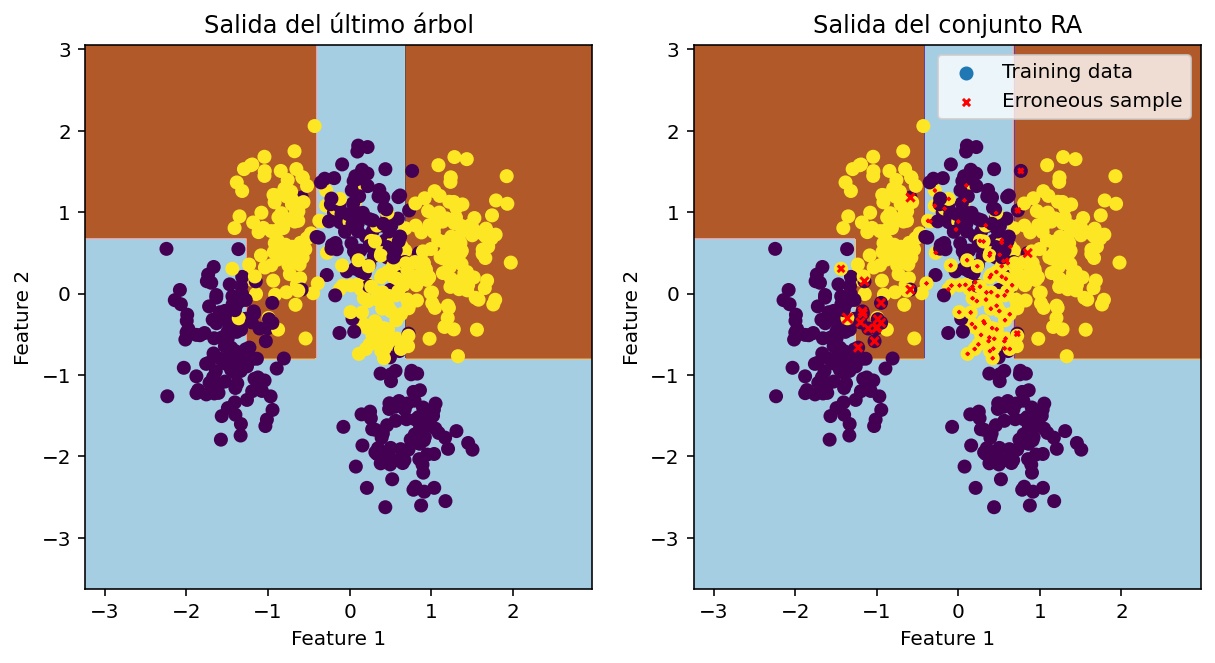

In [65]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_boundary(clf_ens[-1], X_train, Y_train, plt)
plt.title('Salida del último árbol')

plt.subplot(1,2,2)
plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
plt.title('Salida del conjunto RA')
plt.show()


### Paso T: Repetimos este proceso T veces...

In [66]:
from sklearn import tree
N = X_train.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,))
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth) 

T = 20
plt.figure(figsize=(20,25))
for t in range(T):
  # Train a boosted tree (use sample_weight parameter)
  clf_tree.fit(X_train, Y_train, sample_weight=Dt)
  clf_ens.append(copy.copy(clf_tree))
  # Compute tree soft-outputs (interval [-1,1])
  o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
    
  # Compute output weights
  gamma_t = Dt @ (o_t*(2*Y_train-1))
  alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
  alpha_ens.append(alpha_t)
  # Update ensemble  output
  f_pred_train = f_pred_train + alpha_t * o_t
  # Update emphasis function
  Dt = Dt * np.exp(-alpha_t * (o_t*Y_train))
  Dt = Dt /np.sum(Dt)
  # Plot the solution
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plot_boundary(clf_ens[-1], X_train, Y_train, plt)
  plt.title('Paso '+str(t)+': salida del último árbol')
  plt.subplot(1,2,2)
  plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
  plt.title ('Paso '+str(t)+': salida del conjunto')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Modelos de Boosting en sklearn

Podemos encontrar una implementación del clasificador Real AdaBoost en la biblioteca de sklearn. Esta clase, llamada [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier), nos permite utilizar las versiones Discreta y Real del Adaboost ajustando el parámetro `algorithm` a `SAMME` o `SAMME.R`, respectivamente.





### Ejercicio 3

Usa el modelo `AdaBoostClassifier` para entrenar un conjunto de 10 árboles de decisión con profundidad 4. Utiliza las dos implementaciones del Adaboost (`algorithm` = `SAMME` y `algorithm` =  `SAMME.R`) y compara el resultado con el conjunto construido por Bagging en el Ejercicio 1.


#### Solution

In [67]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

max_depth = 4
T =10
nperc = 0.4
#<SOL>
clf = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=T, max_samples=nperc).fit(X_train, Y_train)
acc_ens = clf.score(X_test, Y_test)
print('Bagging accuracy: %2.2f'%(acc_ens))

clf_DA = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=T, algorithm ='SAMME').fit(X_train, Y_train)
acc_ens = clf_DA.score(X_test, Y_test)
print('AdaBoost Discreto accuracy: %2.2f'%(acc_ens))

clf_RA = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4),n_estimators=T, algorithm ='SAMME.R').fit(X_train, Y_train)
acc_ens = clf_RA.score(X_test, Y_test)
print('Real AdaBoost accuracy: %2.2f'%(acc_ens))

#</SOL>

Bagging accuracy: 0.81
AdaBoost Discreto accuracy: 0.88
Real AdaBoost accuracy: 0.85


## Profundizando en el funcionamiento del Boosting

Al igual que con los métodos de Bagging, vamos a analizar la evolución del error, según añadimos clasificadores al conjunto, para entender así su funcionamiento. Para ello, la siguiente celda de código analiza esta evolución para las dos versiones de Adaboost que incluye sklearn.

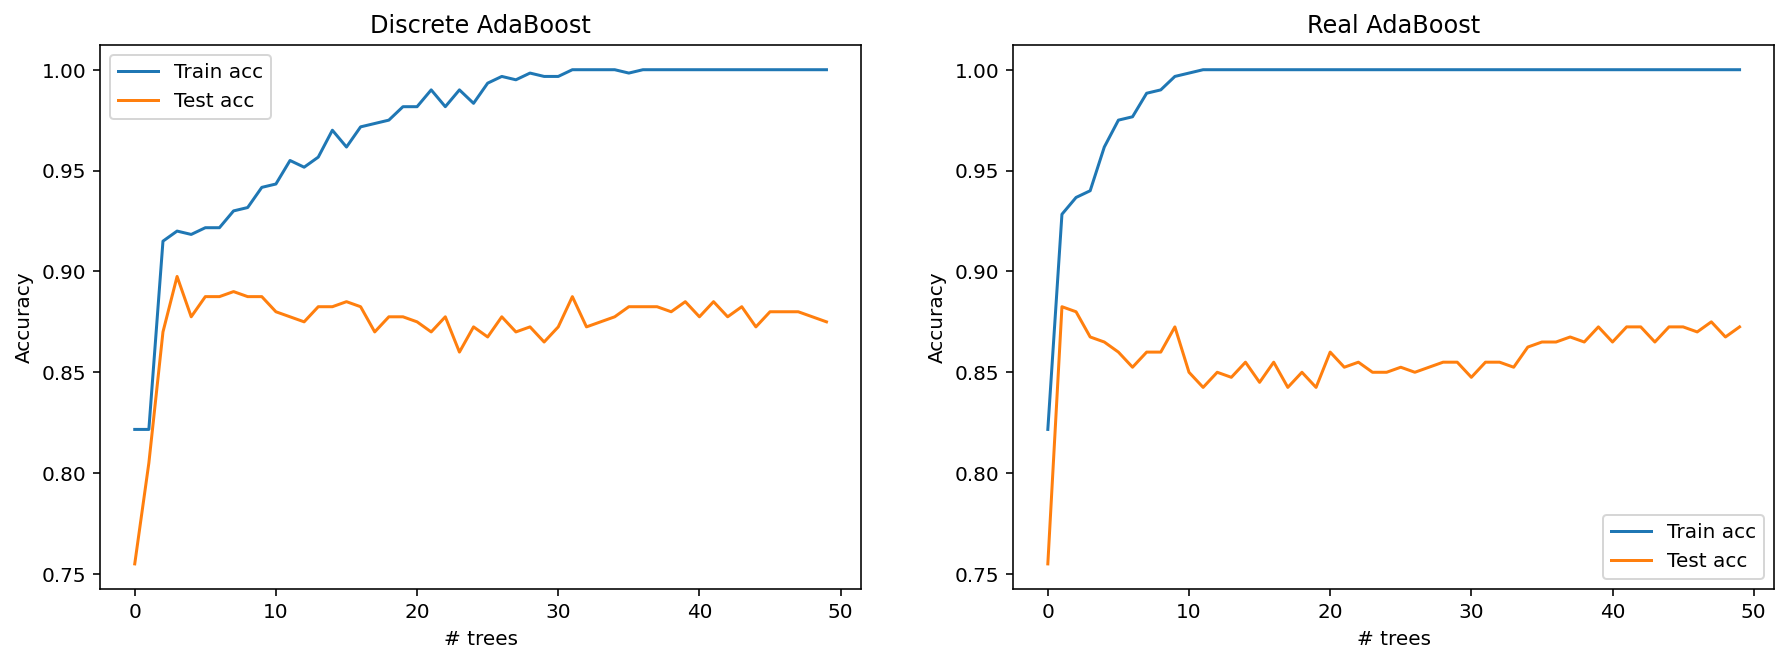

In [68]:
from sklearn.ensemble import AdaBoostClassifier

T =50

DA_acc_tr=[]
DA_acc_test=[]
RA_acc_tr=[]
RA_acc_test=[]

for t in range(1,T+1):
  clf_DA = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4), n_estimators=t, algorithm ='SAMME').fit(X_train, Y_train)
  DA_acc_tr.append(clf_DA.score(X_train, Y_train))
  DA_acc_test.append(clf_DA.score(X_test, Y_test))

  clf_RA = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4),n_estimators=t, algorithm ='SAMME.R').fit(X_train, Y_train)
  RA_acc_tr.append(clf_RA.score(X_train, Y_train))
  RA_acc_test.append(clf_RA.score(X_test, Y_test))


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(DA_acc_tr, label='Train acc')
plt.plot(DA_acc_test, label='Test acc')
plt.legend()
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title("Discrete AdaBoost")

plt.subplot(1,2,2)
plt.plot(RA_acc_tr, label='Train acc')
plt.plot(RA_acc_test, label='Test acc')
plt.legend()
plt.xlabel('# trees')
plt.ylabel('Accuracy')
plt.title("Real AdaBoost")

plt.show()


Analizando estas curvas en detalle, podemos observar varias cosas interesantes que los diferencian de los conjuntos por Bagging.
- Si repetimos el experimento el resultado es el mismo, no hay variabilidad.
- A diferencia del Bagging, la ganancia en el conjunto viene dada por una reducción del sesgo del error (el error sistemático) y no de la varianza. 
- Al añadir más clasificadores al conjunto, podemos encontrarnos dos efectos:
  - Sobreajuste: al seguir enfatizando muestras muy erróneas (outliers) podemos llegar a forzar una frontera que las clasifique correctamente y genere sobreajuste.
  - Aunque el error de entrenamiento llegue al 0%, puede interesar seguir añadiendo clasificadores al conjunto porque podemos ir definiendo una solución que generalice mejor; es decir, el error de test puede mejorar aunque el de entrenamiento sea 0%.

En estas figuras vemos como ambas tendencias se combinan y el error de test fluctúa. 

En resumen, la fortaleza de los modelos de Boosting reside en construir conjuntos con buenas capacidades predictivas conseguidas reduciendo el sesgo del error. Pero puede tender a sobreajustar, por lo que el ajuste de los parámetros del modelo (número de elementos/clasificadores) se convierte en una parte crucial para poder evitar el sobreajuste.

## Boosting como un algoritmo de descenso por gradiente

El algoritmo Real AdaBoost puede reformularse como un algoritmo de construcción de características (*feature engineering*) en el que cada clasificador proporciona una característica nueva al conjunto y estas se combinan con unos pesos $\alpha_t$ para minimizar la función de coste exponencial que minimiza el RA.

De este modo podemos considerar que RA entrena una secuencia de clasificadores para construir unas características $o_t(\mathbf x)$, $t=1, \ldots, T$, de modo que la salida fina del clasificador o conjunto vienen dada por una combinación lineal de las mismas

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

y los pesos de esta combinación se calculan de modo que se minice la siguiente función de coste:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$

Además, para el diseño de estas características, en cada iteración del conjunto, RA añade una nueva variable  $o_t(\mathbf x)$ de modo que se consiga la mayor reducción posible de la función de coste hasta el paso $t$, es decir,

$$ \underset{{o_t(\mathbf x)}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t'=1}^t \alpha_{t'} o_{t'}({\bf x}^{(i)}) {y}^{(i)} \right) = \underset{{o_t(\mathbf x)}}{\operatorname{max}} \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $$

Es decir, buscar el cada paso el $o_t(\mathbf x)$ que proporcione la mayor reducción del coste equivale a maximizar una versión enfatizada de los aciertos del clasificador!!!

Dado que el hecho de añadir  en cada paso un nuevo clasificador o *feature* que minimice la función de coste equivale a ir moviendote en la dirección de su gradiente, esta reformulación o reinterpretetación del RA entra dentro de la familia de modelos de **Gradient Boosting**. La ventaja de esta visión del problema es que podemos elegir diferentes funciones de coste para obtener diferentes modelos de Boosting. De hecho, las versiones para regresión se formulan considerando esta formulación del problema para el error cuadrático medio.


Sklearn también incluye una implementación de esta familia de modelos cuando los clasificadores base son árboles y se encuentran dentro del modelo [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier). Además, esta clase nos permite elegir entre dos funciones de coste para el diseño del conjunto: (1) la función exponencial del RA estandar y (2) la función binomial usada por los modelos de regresión logística.



### Ejercicio 4

Usa el modelo `GradientBoostingClassifier` para entrenar un conjunto de 10 árboles de decisión con profundidad 4 mediante un Gradient Boosting con función de coste exponencial (`loss= ‘exponential’`) y binomial (`loss= ‘deviance’`). Compara el resultado con la obtenida por el `AdaBoostClassifier` con `algorithm` =  `SAMME.R`.

In [69]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

max_depth = 4
T =10
#<SOL>
clf_RA = AdaBoostClassifier(base_estimator= tree.DecisionTreeClassifier(max_depth=4),n_estimators=T, algorithm ='SAMME.R').fit(X_train, Y_train)
acc_ens = clf_RA.score(X_test, Y_test)
print('Real AdaBoost accuracy: %2.2f'%(acc_ens))

clf_GB_Exp = GradientBoostingClassifier(n_estimators=T, max_depth=4, loss= 'exponential').fit(X_train, Y_train)
acc_ens =clf_GB_Exp.score(X_test, Y_test)
print('GradientBoosting accuracy (exponential): %2.2f'%(acc_ens))

clf_GB_Bin = GradientBoostingClassifier(n_estimators=T, max_depth=4, loss= 'deviance').fit(X_train, Y_train)
acc_ens = clf_GB_Bin .score(X_test, Y_test)
print('GradientBoosting accuracy (deviance): %2.2f'%(acc_ens))
#</SOL>

Real AdaBoost accuracy: 0.86
GradientBoosting accuracy (exponential): 0.89
GradientBoosting accuracy (deviance): 0.90


## Libreria XGBoost 

Para la implementación de los métodos de Gradient Boosting es bastante común el uso de la [biblioteca XGBoost](https://xgboost.readthedocs.io/en/latest/index.html), ya que proporciona una implementación eficiente con capacidades de paralelización (en caso de que necesitemos trabajar con grandes conjuntos de datos). Además, tiene una [interfaz de sklearn](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) que nos permite integrarla fácilmente con nuestro código.

Al igual que la implementación de sklearn está diseñada para trabajar con árboles de decisión, pero nos aporta algunas utilidades adicionales:
* Permite hacer *early_stopping*: si porporcionamos un conjunto de validación, va evaluando las prestaciones del conjunto sobre él para decidir en que momento dejar de añadir nuevos árboles (evitando efectos de sobreajuste).
* Permite evaluar el conjunto con un subconjunto de los árboles entrenados.
 
Veamos su funcionamiento y estas utilidades con los siguientes ejemplos:

### Ejemplo 1: Funcionamiento estandar

In [70]:
import xgboost as xgb
T = 10
clf_XGB =xgb.XGBClassifier(n_estimators= T, max_depth=4).fit(X_train, Y_train)
acc_ens = clf_XGB.score(X_test, Y_test)

print('XGBoosting accuracy: %2.2f'%(acc_ens))


XGBoosting accuracy: 0.86


### Ejemplo 2: Evaluación con solo $t$ árboles

In [71]:
from sklearn.metrics import accuracy_score
T = 10
clf_XGB =xgb.XGBClassifier(n_estimators= T, max_depth=4).fit(X_train, Y_train)
Y_pred = clf_XGB.predict(X_test, ntree_limit=1)
acc_ens = accuracy_score(Y_test,Y_pred)
print('XGBoosting accuracy: %2.2f'%(acc_ens))


XGBoosting accuracy: 0.76


### Ejemplo 3: Validación del número de árboles

In [72]:
X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=.4)

T = 10
clf_XGB =xgb.XGBClassifier(n_estimators= T, max_depth=4)
clf_XGB.fit(X_train_sub, Y_train_sub, early_stopping_rounds=4, eval_metric="error",
        eval_set=[(X_val, Y_val)])

evals_result = clf_XGB.evals_result()
evals_result

[0]	validation_0-error:0.245833
Will train until validation_0-error hasn't improved in 4 rounds.
[1]	validation_0-error:0.245833
[2]	validation_0-error:0.245833
[3]	validation_0-error:0.245833
[4]	validation_0-error:0.241667
[5]	validation_0-error:0.241667
[6]	validation_0-error:0.241667
[7]	validation_0-error:0.241667
[8]	validation_0-error:0.241667
Stopping. Best iteration:
[4]	validation_0-error:0.241667



{'validation_0': {'error': [0.245833,
   0.245833,
   0.245833,
   0.245833,
   0.241667,
   0.241667,
   0.241667,
   0.241667]}}

# 4. Combinación de clasificadores o *Stacking*

El *stacking* es otro tipo de conjuntos, en el que directamente se obtiene un conjunto a partir de la combinación de las predicciones de varios clasificadores diferentes como puede ser un K-NN, LR, SVM, Tree, .... La idea es que si estos modelos proporcionan salidas diferentes (diversidad) simplemente por el hecho de ser modelos diferentes combinando sus salidas podremos reducir la varianza final del error.

Hay esquemas que utilizan esta idea haciendo diferentes capas de agrupamiento donde los clasificadores se agrupan en diferentes niveles. El esquema más sencillo, y habitual, con una única capa de agregación se muestra en la siguiente figura:
<img align="center" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/ensembles/Stacked.png" width=80%>

Si queremos  implementar directamente este modelo y emplear esquemas de CV utilizando herramentas como GridSearch no es sencillo definir el pipeline.  Sin embargo, la libreria [ML-Ensemble](https://mlens.readthedocs.io/en/0.1.x/) es totalmente compatible con skelarn y nos simplifica este proceso.

En el siguiente ejemplo vemos como definir un conjunto por *stacking*  tomando como  clasificadores base `Random Forest`, `Extra Trees`, `KNeighbors`, `SVC`, `Ridge Classifier` y usando la clase [`SuperLearner`](https://mlens.readthedocs.io/en/0.1.x/source/mlens.ensemble/) de ML-Ensemble.


In [73]:
!pip install mlens

In [74]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define ensemble model
ensemble = SuperLearner()

# Define set of classifiers of the input layer and add them to the ensemble
learners = [KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]
ensemble.add(learners)

# Define output layer
ensemble.add_meta(LogisticRegression())

# Train and test the model
ensemble.fit(X_train, Y_train)
Y_pred = ensemble.predict(X_test)
acc_ens = accuracy_score(Y_test,Y_pred)

print('Stacked ensemble accuracy: %2.2f'%(acc_ens))

Stacked ensemble accuracy: 0.88
